# Importing Packages


In [2]:
# -----------------------------
# 1. Imports and Seed Setup
# -----------------------------
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from tqdm import tqdm
import seaborn as sns
import json
from sklearn.preprocessing import StandardScaler
import joblib  # for saving the scaler

import warnings
warnings.filterwarnings("ignore")  

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

import torch.backends.cudnn as cudnn
import time
cudnn.deterministic = True
cudnn.benchmark = False

# EDA

In [3]:
df = pd.read_csv('..\data\DrivAerNetPlusPlus_Drag_8k_cleaned.csv')
df.describe()

,Average Cd
count,7713.000000
mean,0.284412
std,0.037232
min,0.201138
25%,0.255859
50%,0.282987
75%,0.311521
max,0.383330


In [4]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# Get current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Print GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")
    print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024**2, "MB")


CUDA Available: True
Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
Memory Allocated: 0.0 MB
Memory Cached: 0.0 MB


<Axes: xlabel='Average Cd', ylabel='Count'>

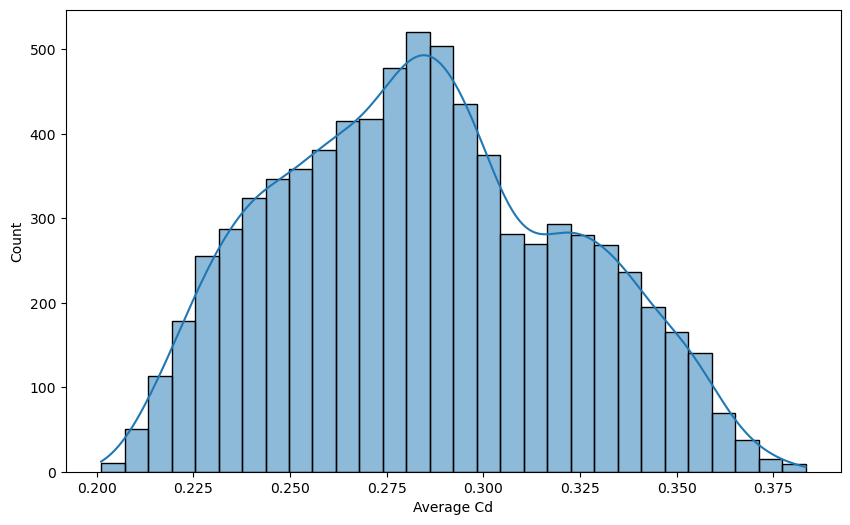

In [5]:
# Plot the pdf graph for Average Drag Coefficient (Cd)
plt.figure(figsize=(10, 6))
sns.histplot(df['Average Cd'], bins=30, kde=True)

# Pepraring Scaler Function and Global variables

In [6]:
# -----------------------------
# 1.2. Prepaing Scaler
# -----------------------------

# Subset to only training car IDs
with open("../data/subset_dir/train_design_ids.txt") as f:
    train_ids = [line.strip() for line in f]

df_train = df[df["Design"].isin(train_ids)]
scaler = StandardScaler()
scaler.fit(df_train[["Average Cd"]])

print(f"Scaler mean: {scaler.mean_[0]:.6f}, std: {scaler.scale_[0]:.6f}")

# Save scaler to disk
os.makedirs("../outputs", exist_ok=True)
joblib.dump(scaler, "../outputs/cd_scaler.pkl")

Scaler mean: 0.284506, std: 0.037448


['../outputs/cd_scaler.pkl']

In [7]:
# -----------------------------
# 1.3. Global Variables
# -----------------------------

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# point_net_input_dim = 2
# point_net_embedding_dim = 512
# lstm_input_dim = point_net_embedding_dim
# lstm_hidden_dim = 512
# bidirectional = True
# number_of_layers = 2
# cd_regressor_input_dim = lstm_hidden_dim * 2 if bidirectional else lstm_hidden_dim
# batch_size = 2
# checkpoint_dir="../outputs/checkpoints3"
# analysis_output_dir='../outputs/analysis'
# scaler = joblib.load("../outputs/cd_scaler.pkl")

In [8]:
# -----------------------------
# 1.3. Global Variables
# -----------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

point_net_input_dim = 2
point_net_embedding_dim = 256
lstm_input_dim = point_net_embedding_dim
lstm_hidden_dim = 256
bidirectional = True
number_of_layers = 2
cd_regressor_input_dim = lstm_hidden_dim * 2 if bidirectional else lstm_hidden_dim
batch_size = 4

model_checkpoint_dir="../outputs/checkpoints3"
analysis_output_dir='../outputs/analysis'

scaler = joblib.load("../outputs/cd_scaler.pkl")
assert hasattr(scaler, "mean_"), "Scaler not loaded correctly"


# Model

In [9]:
# # -----------------------------
# # 2. Enhanced PointNet2D (Optimized)
# # -----------------------------
# class PointNet2D(nn.Module):
#     def __init__(self, input_dim=2, emb_dim=512):
#         super(PointNet2D, self).__init__()

#         self.mlp = nn.Sequential(
#             nn.Conv1d(input_dim, 64, 1),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Conv1d(64, 128, 1),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Conv1d(128, 256, 1),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Conv1d(256, emb_dim, 1),
#             nn.BatchNorm1d(emb_dim),
#             nn.ReLU()
#         )

#     def forward(self, x, mask=None):
#         # Ensure input and model are on the same device
#         assert x.device == next(self.parameters()).device, "Input and model are on different devices!"

#         # x: (B, N, 2) -> (B, 2, N)
#         x = x.transpose(1, 2)
#         features = self.mlp(x)  # (B, emb_dim, N)

#         if mask is not None:
#             mask = mask.unsqueeze(1)  # (B, 1, N)
#             features = features.masked_fill(mask == 0, float('-inf'))

#         embedding = torch.max(features, dim=2)[0]  # (B, emb_dim)
#         return embedding

In [10]:
# -----------------------------
# LightPointNet2D: Efficient 2D PointNet
# -----------------------------
class PointNet2D(nn.Module):
    def __init__(self, input_dim=2, emb_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv1d(input_dim, 32, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(32, 64, 1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, emb_dim, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, mask=None):
        # x: (B*N, P, 2) → (B*N, 2, P)
        x = x.transpose(1, 2)  # (B, 2, N)
        features = self.mlp(x)  # (B, emb_dim, N)

        if mask is not None:
            mask = mask.unsqueeze(1)  # (B, 1, N)
            features = features.masked_fill(mask == 0, float('-inf'))

        # Global max pooling
        embedding = torch.max(features, dim=2)[0]  # (B, emb_dim)
        return embedding


In [11]:
# -----------------------------
# 3. LSTM Slice Encoder (Optimized)
# -----------------------------
class LSTMSliceEncoder(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=512, num_layers=2, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.2  # Dropout between layers
        )

    def forward(self, x):
        # Ensure input and model are on the same device
        assert x.device == next(self.parameters()).device, "Input and model are on different devices!"

        # x: (B, S, D)
        _, (h_n, _) = self.lstm(x)
        if self.lstm.bidirectional:
            return torch.cat((h_n[-2], h_n[-1]), dim=-1)  # (B, 2H)
        else:
            return h_n[-1]  # (B, H)


In [12]:
# -----------------------------
# 4. Cd Regressor MLP (Optimized)
# -----------------------------
class CdRegressor(nn.Module):
    def __init__(self, input_dim=1024):  # 512 * 2 from BiLSTM
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Ensure input and model are on the same device
        assert x.device == next(self.parameters()).device, "Input and model are on different devices!"
        return self.net(x).squeeze(1)


In [13]:
# -----------------------------
# 5. Full Model Assembly (Optimized)
# -----------------------------
class CdPredictorNet(nn.Module):
    def __init__(self, pointnet, lstm_encoder, regressor):
        super().__init__()
        self.pointnet = pointnet
        self.lstm_encoder = lstm_encoder
        self.regressor = regressor

    def forward(self, slices, point_mask, slice_mask):
        # slices: (B, S, N, D)
        B, S, N, D = slices.shape

        # Optional: Device consistency check
        assert slices.device == next(self.parameters()).device, "Input slices not on same device as model."

        # Flatten slices and masks
        flat_slices = slices.reshape(B * S, N, D)
        flat_mask = point_mask.reshape(B * S, N)

        # Encode each slice
        slice_embs = self.pointnet(flat_slices, flat_mask)  # (B*S, 256)
        slice_embs = slice_embs.view(B, S, -1)  # (B, S, 256)

        # Temporal encoding with LSTM
        car_emb = self.lstm_encoder(slice_embs)  # (B, 1024 if bidirectional)

        # Final regression
        return self.regressor(car_emb)


# Dataset loader and Model Summary

In [14]:
# -----------------------------
# 6. Dataset Loader (Optimized)
# -----------------------------
class CarSlicesDataset(torch.utils.data.Dataset):
    def __init__(self, ids_txt, npz_dir, csv_path, max_cars=None, scaler = None):
        """
        Args:
            ids_txt (str): Path to the text file containing car IDs.
            npz_dir (str): Directory containing the .npz files.
            csv_path (str): Path to the CSV file with Cd values.
            max_cars (int, optional): Limit the number of cars to load. Defaults to None.
            scaler (object, optional): Scaler object for normalizing Cd values. Defaults to None.
        """
        self.car_ids = [line.strip() for line in open(ids_txt)]
        if max_cars:
            self.car_ids = self.car_ids[:max_cars]
        self.npz_dir = npz_dir
        self.cd_map = pd.read_csv(csv_path).set_index("Design")["Average Cd"].to_dict()
        self.scaler = scaler if scaler else None

    def __len__(self):
        return len(self.car_ids)

    def __getitem__(self, idx):
        
        car_id = self.car_ids[idx]
        data = np.load(os.path.join(self.npz_dir, f"{car_id}_axis-x.npz"))

        # Keep in NumPy for now (better for pin_memory and batch collation)
        slices = data["slices"].astype(np.float32)         # (80, 6500, 2)
        point_mask = data["point_mask"].astype(np.float32) # (80, 6500)
        slice_mask = data["slice_mask"].astype(np.float32) # (80,)
        cd_value = np.float32(self.cd_map[car_id])

        if self.scaler:
            cd_value = self.scaler.transform([[cd_value]])[0, 0]

        return slices, point_mask, slice_mask, cd_value


In [15]:
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
lstm_encoder = LSTMSliceEncoder(input_dim=lstm_input_dim, hidden_dim=lstm_hidden_dim, num_layers=number_of_layers, bidirectional=bidirectional)
regressor = CdRegressor(input_dim=cd_regressor_input_dim)
model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

# Print model summary (example input: batch_size=2, slices=80, points=6500, dim=2)
summary(model, input_data=(
    torch.zeros(2, 80, 6500, 2).to(device),
    torch.ones(2, 80, 6500).to(device),
    torch.ones(2, 80).to(device)
))


Layer (type:depth-idx)                   Output Shape              Param #
CdPredictorNet                           [2]                       --
├─PointNet2D: 1-1                        [160, 256]                --
│    └─Sequential: 2-1                   [160, 256, 6500]          --
│    │    └─Conv1d: 3-1                  [160, 32, 6500]           96
│    │    └─ReLU: 3-2                    [160, 32, 6500]           --
│    │    └─Conv1d: 3-3                  [160, 64, 6500]           2,112
│    │    └─ReLU: 3-4                    [160, 64, 6500]           --
│    │    └─Conv1d: 3-5                  [160, 256, 6500]          16,640
│    │    └─ReLU: 3-6                    [160, 256, 6500]          --
├─LSTMSliceEncoder: 1-2                  [2, 512]                  --
│    └─LSTM: 2-2                         [2, 80, 512]              2,629,632
├─CdRegressor: 1-3                       [2]                       --
│    └─Sequential: 2-3                   [2, 1]                    --
│

# Training Loop

## Helper Function

In [16]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import time
import torch

def evaluate_model(model, val_loader, device, scaler):
    model.eval()
    preds, trues = [], []

    start = time.time()
    with torch.no_grad():
        for slices, point_mask, slice_mask, cd_gt in val_loader:
            slices = slices.to(device, non_blocking=True)
            point_mask = point_mask.to(device, non_blocking=True)
            slice_mask = slice_mask.to(device, non_blocking=True)
            cd_gt = cd_gt.to(device, non_blocking=True).float()

            pred = model(slices, point_mask, slice_mask)
            preds.append(pred)
            trues.append(cd_gt)

    preds = torch.cat(preds).cpu().numpy()
    trues = torch.cat(trues).cpu().numpy()

    if scaler:
        preds = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
        trues = scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    # Metrics
    r2 = r2_score(trues, preds)
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    mape = np.mean(np.abs((trues - preds) / (trues + 1e-8))) * 100  # small constant for stability

    # Normalized Absolute Error (based on range)
    value_range = np.max(trues) - np.min(trues)
    nmae = np.mean(np.abs(trues - preds) / (value_range + 1e-8))

    print(f"\n📊 Validation Metrics:")
    print(f"🔹 R²   = {r2:.4f}")
    print(f"🔹 MSE  = {mse:.6f}")
    print(f"🔹 RMSE = {rmse:.6f}")
    print(f"🔹 MAE  = {mae:.6f}")
    print(f"🔹 MAPE = {mape:.2f}%")
    print(f"🔹 NMAE  = {nmae:.4f}")
    print(f"⏱️ Time taken: {time.time() - start:.2f} seconds")

    return {"r2": r2, "mse": mse, "rmse": rmse, "mae": mae, "mape": mape, "nmae": nmae}


## Main Training Loop

In [17]:
# -----------------------------
# 7. Training Loop (Updated)
# -----------------------------

def train_model(resume=True, num_epochs=50, max_cars=2000, validation_set_size=200,
                checkpoint_dir=model_checkpoint_dir, early_stopping_patience=5):
    import time

    # Initialize model using global config
    pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
    lstm_encoder = LSTMSliceEncoder(
        input_dim=lstm_input_dim,
        hidden_dim=lstm_hidden_dim,
        num_layers=number_of_layers,
        bidirectional=bidirectional
    )
    regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.SmoothL1Loss()

    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 1
    best_loss = float("inf")
    patience_counter = 0
    epoch_losses = []

    # Resume from checkpoint if available
    if resume:
        checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*_loss*.pt")))
        if checkpoints:
            latest_ckpt = checkpoints[-1]
            print(f"🔄 Resuming from checkpoint: {latest_ckpt}")
            state = torch.load(latest_ckpt, map_location=device)
            model.load_state_dict(state['model'])
            optimizer.load_state_dict(state['optimizer'])
            start_epoch = state['epoch'] + 1
            epoch_losses = state.get('epoch_losses', [])
            best_loss = min(epoch_losses) if epoch_losses else float("inf")
        else:
            print("⏩ No previous checkpoint found, starting fresh.")

    # Dataset & Dataloaders
    train_dataset = CarSlicesDataset(
        ids_txt="../data/subset_dir/train_design_ids.txt",
        npz_dir="../outputs/pad_masked_slices",
        csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
        max_cars=max_cars,
        scaler=scaler
    )
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
    )

    val_dataset = CarSlicesDataset(
        ids_txt="../data/subset_dir/val_design_ids.txt",
        npz_dir="../outputs/pad_masked_slices",
        csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
        max_cars=validation_set_size,
        scaler=scaler
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
    )

    print(f"📦 Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples.")

    try:
        for epoch in range(start_epoch, num_epochs + 1):
            model.train()
            total_loss = 0.0
            start_time = time.time()
            pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", unit="batch")

            for slices, point_mask, slice_mask, cd_gt in pbar:

                slices = slices.to(device, non_blocking=True)
                point_mask = point_mask.to(device, non_blocking=True)
                slice_mask = slice_mask.to(device, non_blocking=True)
                cd_gt = cd_gt.to(device, non_blocking=True).float()

                pred = model(slices, point_mask, slice_mask)
                loss = loss_fn(pred, cd_gt)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batch_loss = loss.item() * slices.size(0)
                total_loss += batch_loss
                pbar.set_postfix(loss=batch_loss / slices.size(0))

            avg_loss = total_loss / len(train_dataloader.dataset)
            epoch_losses.append(avg_loss)
            print(f"\n✅ Epoch {epoch}: Avg SmoothL1 Loss = {avg_loss:.7f}")

            # 🔍 Validation
            print(f"🔍 Evaluating on validation set:")
            evaluate_model(model, val_loader, device, scaler)

            print(f"⏱️ Epoch Time: {time.time() - start_time:.2f}s")

            # 💾 Save checkpoint
            ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch:02d}_loss_{avg_loss:.8f}.pt")
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch_losses': epoch_losses
            }, ckpt_path)
            print(f"💾 Checkpoint saved: {ckpt_path}")

            # 🏆 Save best model separately
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
                print("🏆 Best model updated.")
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"🛑 Early stopping at epoch {epoch}.")
                    break

            print("-" * 60)

    except KeyboardInterrupt:
        print("\n⛔ Interrupted. Saving checkpoint...")
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch_losses': epoch_losses
        }, os.path.join(checkpoint_dir, f"interrupted_epoch_{epoch}.pt"))
        print("🧷 Last checkpoint saved.")

    return model, epoch_losses

## Debugging Training Loop

In [18]:
# # -----------------------------
# # 7. Training Loop (Degubbing)
# # -----------------------------

# def train_model(resume=True, num_epochs=50, max_cars=2000,
#                 checkpoint_dir=model_checkpoint_dir, early_stopping_patience=5):
#     import time

#     # Initialize model using global config
#     pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
#     lstm_encoder = LSTMSliceEncoder(
#         input_dim=lstm_input_dim,
#         hidden_dim=lstm_hidden_dim,
#         num_layers=number_of_layers,
#         bidirectional=bidirectional
#     )
#     regressor = CdRegressor(input_dim=cd_regressor_input_dim)
#     model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     loss_fn = nn.SmoothL1Loss()

#     os.makedirs(checkpoint_dir, exist_ok=True)
#     start_epoch = 1
#     best_loss = float("inf")
#     patience_counter = 0
#     epoch_losses = []

#     # Resume from checkpoint if available
#     if resume:
#         checkpoints = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*_loss*.pt")))
#         if checkpoints:
#             latest_ckpt = checkpoints[-1]
#             print(f"🔄 Resuming from checkpoint: {latest_ckpt}")
#             state = torch.load(latest_ckpt, map_location=device)
#             model.load_state_dict(state['model'])
#             optimizer.load_state_dict(state['optimizer'])
#             start_epoch = state['epoch'] + 1
#             epoch_losses = state.get('epoch_losses', [])
#             best_loss = min(epoch_losses) if epoch_losses else float("inf")
#         else:
#             print("⏩ No previous checkpoint found, starting fresh.")

#     # Dataset & Dataloaders
#     train_dataset = CarSlicesDataset(
#         ids_txt="../data/subset_dir/train_design_ids.txt",
#         npz_dir="../outputs/pad_masked_slices",
#         csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
#         max_cars=max_cars,
#         scaler=scaler
#     )
#     train_dataloader = torch.utils.data.DataLoader(
#         train_dataset, batch_size=batch_size, shuffle=True,
#         num_workers = 0,
#         pin_memory = False,
#         persistent_workers = False
#     )

#     val_dataset = CarSlicesDataset(
#         ids_txt="../data/subset_dir/val_design_ids.txt",
#         npz_dir="../outputs/pad_masked_slices",
#         csv_path="../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv",
#         scaler=scaler
#     )
#     val_loader = torch.utils.data.DataLoader(
#         val_dataset,
#         batch_size=4,
#         shuffle=False,
#         num_workers = 4,
#         pin_memory = False,
#         persistent_workers = False
#     )

#     print(f"📦 Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples.")

#     try:
#         for epoch in range(start_epoch, num_epochs + 1):
#             model.train()
#             total_loss = 0.0
#             start_time = time.time()
#             pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", unit="batch")

#             for slices, point_mask, slice_mask, cd_gt in pbar:
                
#                 start = time.time()
                
#                 slices = slices.to(device, non_blocking=True)
#                 point_mask = point_mask.to(device, non_blocking=True)
#                 slice_mask = slice_mask.to(device, non_blocking=True)
#                 cd_gt = cd_gt.to(device, non_blocking=True).float()

#                 print(f"⏱️ Batch load time: {time.time() - start:.2f} sec")

#                 start = time.time()

#                 pred = model(slices, point_mask, slice_mask)
#                 loss = loss_fn(pred, cd_gt)

#                 print(f"⏱️ Batch forward time: {time.time() - start:.2f} sec")

#                 start = time.time()

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 print(f"⏱️ Batch backward time: {time.time() - start:.2f} sec")

#                 start = time.time()

#                 batch_loss = loss.item() * slices.size(0)
#                 total_loss += batch_loss
#                 pbar.set_postfix(loss=batch_loss / slices.size(0))

#                 print(f"⏱️ Batch update time: {time.time() - start:.2f} sec")

#             avg_loss = total_loss / len(train_dataloader.dataset)
#             epoch_losses.append(avg_loss)
#             print(f"\n✅ Epoch {epoch}: Avg SmoothL1 Loss = {avg_loss:.7f}")

#             # 🔍 Validation
#             print(f"🔍 Evaluating on validation set:")
#             evaluate_model_on_val(model, val_loader, device, scaler , val_set_size=200)

#             print(f"⏱️ Epoch Time: {time.time() - start_time:.2f}s")

#             # 💾 Save checkpoint
#             ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch:02d}_loss_{avg_loss:.8f}.pt")
#             torch.save({
#                 'epoch': epoch,
#                 'model': model.state_dict(),
#                 'optimizer': optimizer.state_dict(),
#                 'epoch_losses': epoch_losses
#             }, ckpt_path)
#             print(f"💾 Checkpoint saved: {ckpt_path}")

#             # 🏆 Save best model separately
#             if avg_loss < best_loss:
#                 best_loss = avg_loss
#                 patience_counter = 0
#                 torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model.pt"))
#                 print("🏆 Best model updated.")
#             else:
#                 patience_counter += 1
#                 if patience_counter >= early_stopping_patience:
#                     print(f"🛑 Early stopping at epoch {epoch}.")
#                     break

#             print("-" * 60)

#     except KeyboardInterrupt:
#         print("\n⛔ Interrupted. Saving checkpoint...")
#         torch.save({
#             'epoch': epoch,
#             'model': model.state_dict(),
#             'optimizer': optimizer.state_dict(),
#             'epoch_losses': epoch_losses
#         }, os.path.join(checkpoint_dir, f"interrupted_epoch_{epoch}.pt"))
#         print("🧷 Last checkpoint saved.")

#     return model, epoch_losses

# Training Model

In [19]:
model, loss_log = train_model(
    resume=True,                        # Set to True if you want to continue from a saved checkpoint
    num_epochs=100,
    max_cars=None,                       # Use entire dataset
    checkpoint_dir=model_checkpoint_dir,
    early_stopping_patience=5
)

🔄 Resuming from checkpoint: ../outputs/checkpoints3\epoch_99_loss_0.01518300.pt
📦 Training on 5398 samples, validating on 200 samples.


Epoch 100:   1%|          | 12/1350 [00:06<11:32,  1.93batch/s, loss=0.016]  


⛔ Interrupted. Saving checkpoint...
🧷 Last checkpoint saved.


# Evaluation

In [20]:
import os
import glob
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_all_checkpoints(checkpoint_dir="../outputs/temp_checkpoints", output_dir="../outputs/temp_analysis"):
    os.makedirs(output_dir, exist_ok=True)
    
    checkpoint_paths = sorted(glob.glob(os.path.join(checkpoint_dir, "epoch_*.pt")))
    all_epoch_losses = []
    epoch_numbers = []

    print("\n📋 Epoch-wise Loss Summary:")
    for ckpt_path in checkpoint_paths:
        try:
            checkpoint = torch.load(ckpt_path, map_location="cpu")
            losses = checkpoint.get("epoch_losses", [])
            epoch = checkpoint.get("epoch", None)

            if epoch is not None and losses:
                epoch_numbers.append(epoch)
                last_loss = losses[-1]
                all_epoch_losses.append(last_loss)
                print(f"Epoch {epoch:02d} → Loss: {last_loss:.7f}")

        except Exception as e:
            print(f"⚠️ Skipped {ckpt_path}: {e}")

    if not epoch_numbers:
        print("❌ No valid checkpoints found.")
        return

    # Save compiled loss log
    loss_log_path = os.path.join(output_dir, "compiled_epoch_losses.json")
    with open(loss_log_path, "w") as f:
        json.dump({
            "epoch_numbers": epoch_numbers,
            "epoch_losses": all_epoch_losses
        }, f, indent=2)
    print(f"\n📄 Saved compiled loss log to: {loss_log_path}")

    # Plot loss curve
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=epoch_numbers, y=all_epoch_losses, marker="o")
    plt.title("📉 Training Loss Curve from Checkpoints")
    plt.xlabel("Epoch")
    plt.ylabel("SmoothL1 Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "loss_curve_from_ckpts.png"))
    plt.close()

    # Plot deltas
    if len(all_epoch_losses) > 1:
        loss_deltas = [all_epoch_losses[i] - all_epoch_losses[i-1] for i in range(1, len(all_epoch_losses))]
        plt.figure(figsize=(8, 5))
        sns.barplot(x=epoch_numbers[1:], y=loss_deltas)
        plt.title("📊 Δ Loss Between Checkpoints")
        plt.xlabel("Epoch")
        plt.ylabel("Δ Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "loss_deltas_from_ckpts.png"))
        plt.close()

    print(f"✅ Done analyzing {len(epoch_numbers)} checkpoints")

In [21]:
analyze_all_checkpoints(checkpoint_dir=model_checkpoint_dir, output_dir=analysis_output_dir) 


📋 Epoch-wise Loss Summary:
Epoch 01 → Loss: 0.1635625
Epoch 01 → Loss: 0.2464958
Epoch 02 → Loss: 0.1042404
Epoch 02 → Loss: 0.2155954
Epoch 03 → Loss: 0.0837441
Epoch 03 → Loss: 0.2063399
Epoch 04 → Loss: 0.0860357
Epoch 05 → Loss: 0.0824505
Epoch 06 → Loss: 0.0715279
Epoch 07 → Loss: 0.0671776
Epoch 08 → Loss: 0.0637395
Epoch 09 → Loss: 0.0586883
Epoch 100 → Loss: 0.0171010
Epoch 10 → Loss: 0.0572876
Epoch 11 → Loss: 0.0540730
Epoch 12 → Loss: 0.0495315
Epoch 13 → Loss: 0.0461043
Epoch 14 → Loss: 0.0459189
Epoch 15 → Loss: 0.0455986
Epoch 16 → Loss: 0.0438680
Epoch 17 → Loss: 0.0424614
Epoch 18 → Loss: 0.0422533
Epoch 19 → Loss: 0.0410204
Epoch 20 → Loss: 0.0398268
Epoch 21 → Loss: 0.0387932
Epoch 22 → Loss: 0.0394746
Epoch 23 → Loss: 0.0366771
Epoch 24 → Loss: 0.0372471
Epoch 25 → Loss: 0.0361738
Epoch 26 → Loss: 0.0356182
Epoch 27 → Loss: 0.0354190
Epoch 28 → Loss: 0.0344296
Epoch 29 → Loss: 0.0343859
Epoch 30 → Loss: 0.0342555
Epoch 31 → Loss: 0.0338324
Epoch 32 → Loss: 0.0330284

In [22]:
def load_best_model(model_checkpoint_dir = model_checkpoint_dir):
    """
    Loads the best model saved in `best_model.pt` using global architecture settings.
    """
    best_model_path = os.path.join(model_checkpoint_dir, "best_model.pt")

    # Recreate model architecture using global config
    pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
    lstm_encoder = LSTMSliceEncoder(
        input_dim=lstm_input_dim,
        hidden_dim=lstm_hidden_dim,
        num_layers=number_of_layers,
        bidirectional=bidirectional
    )
    regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    best_model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

    if os.path.exists(best_model_path):
        best_model.load_state_dict(torch.load(best_model_path, map_location=device))
        best_model.eval()
        print(f"🏆 Loaded best model from: {best_model_path}")
    else:
        print(f"❌ No best_model.pt found at: {best_model_path}")

    return best_model

In [23]:
best_model = load_best_model(model_checkpoint_dir)  # New clean instance, separate from training-time model

🏆 Loaded best model from: ../outputs/checkpoints3\best_model.pt


In [24]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assumes `best_model` is already loaded and set to eval mode
assert best_model is not None, "Best model is not loaded."

# Load test set IDs
id_file = "../data/subset_dir/test_design_ids.txt"
with open(id_file) as f:
    test_ids = [line.strip() for line in f]

# Ground-truth Cd map
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
cd_map = dict(zip(df["Design"], df["Average Cd"]))

# Evaluation setup
best_model.eval()
preds, trues, ids_used = [], [], []

for car_id in test_ids:
    npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    if not os.path.exists(npz_path):
        print(f"⚠️ Missing file: {car_id}")
        continue

    data = np.load(npz_path)
    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)

    with torch.no_grad():
        cd_scaled = best_model(slices, point_mask, slice_mask).item()
        cd_pred = scaler.inverse_transform([[cd_scaled]])[0, 0]

    cd_true = cd_map[car_id]
    preds.append(cd_pred)
    trues.append(cd_true)
    ids_used.append(car_id)

    # print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

# Final metrics
r2 = r2_score(trues, preds)
mse = mean_squared_error(trues, preds)
mae = mean_absolute_error(trues, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
nmae = np.mean(np.abs(np.array(trues) - np.array(preds)) / (np.max(trues) - np.min(trues))) * 100

print("\n📊 Evaluation Summary:")
print(f"🔹 R² Score     : {r2:.4f}")
print(f"🔹 MSE          : {mse:.6f}")
print(f"🔹 RMSE         : {rmse:.6f}")
print(f"🔹 MAE          : {mae:.6f}")
print(f"🔹 MAPE         : {mape:.2f}%")
print(f"🔹 NMAE         : {nmae:.4f}")
print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

# Save predictions
os.makedirs("../outputs/eval", exist_ok=True)
out_path = f"../outputs/eval/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
pd.DataFrame({
    "Design ID": ids_used,
    "Predicted Cd": preds,
    "True Cd": trues
}).to_csv(out_path, index=False)
print(f"💾 Saved predictions to: {out_path}")



📊 Evaluation Summary:
🔹 R² Score     : 0.9441
🔹 MSE          : 0.000078
🔹 RMSE         : 0.008847
🔹 MAE          : 0.006645
🔹 MAPE         : 2.41%
🔹 NMAE         : 3.8950
🔹 Cars tested  : 1158 / 1158
💾 Saved predictions to: ../outputs/eval/cd_predictions_test_design_ids.csv


In [25]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assumes `best_model` is already loaded and set to eval mode
assert best_model is not None, "Best model is not loaded."

# Load test set IDs
id_file = "../data/subset_dir/val_design_ids.txt"
with open(id_file) as f:
    test_ids = [line.strip() for line in f]

# Ground-truth Cd map
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
cd_map = dict(zip(df["Design"], df["Average Cd"]))

# Evaluation setup
best_model.eval()
preds, trues, ids_used = [], [], []

for car_id in test_ids:
    npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    if not os.path.exists(npz_path):
        print(f"⚠️ Missing file: {car_id}")
        continue

    data = np.load(npz_path)
    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)

    with torch.no_grad():
        cd_scaled = best_model(slices, point_mask, slice_mask).item()
        cd_pred = scaler.inverse_transform([[cd_scaled]])[0, 0]

    cd_true = cd_map[car_id]
    preds.append(cd_pred)
    trues.append(cd_true)
    ids_used.append(car_id)

    # print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

# Final metrics
r2 = r2_score(trues, preds)
mse = mean_squared_error(trues, preds)
mae = mean_absolute_error(trues, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
nmae = np.mean(np.abs(np.array(trues) - np.array(preds)) / (np.max(trues) - np.min(trues))) * 100

print("\n📊 Evaluation Summary:")
print(f"🔹 R² Score     : {r2:.4f}")
print(f"🔹 MSE          : {mse:.6f}")
print(f"🔹 RMSE         : {rmse:.6f}")
print(f"🔹 MAE          : {mae:.6f}")
print(f"🔹 MAPE         : {mape:.2f}%")
print(f"🔹 NMAE         : {nmae:.4f}")
print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

# Save predictions
os.makedirs("../outputs/eval", exist_ok=True)
out_path = f"../outputs/eval/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
pd.DataFrame({
    "Design ID": ids_used,
    "Predicted Cd": preds,
    "True Cd": trues
}).to_csv(out_path, index=False)
print(f"💾 Saved predictions to: {out_path}")



📊 Evaluation Summary:
🔹 R² Score     : 0.9372
🔹 MSE          : 0.000081
🔹 RMSE         : 0.009022
🔹 MAE          : 0.006693
🔹 MAPE         : 2.45%
🔹 NMAE         : 3.8542
🔹 Cars tested  : 1157 / 1157
💾 Saved predictions to: ../outputs/eval/cd_predictions_val_design_ids.csv


In [26]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assumes `best_model` is already loaded and set to eval mode
assert best_model is not None, "Best model is not loaded."

# Load test set IDs
id_file = "../data/subset_dir/train_design_ids.txt"
with open(id_file) as f:
    test_ids = [line.strip() for line in f]

# Ground-truth Cd map
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
cd_map = dict(zip(df["Design"], df["Average Cd"]))

# Evaluation setup
best_model.eval()
preds, trues, ids_used = [], [], []

for car_id in test_ids:
    npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    if not os.path.exists(npz_path):
        print(f"⚠️ Missing file: {car_id}")
        continue

    data = np.load(npz_path)
    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)

    with torch.no_grad():
        cd_scaled = best_model(slices, point_mask, slice_mask).item()
        cd_pred = scaler.inverse_transform([[cd_scaled]])[0, 0]

    cd_true = cd_map[car_id]
    preds.append(cd_pred)
    trues.append(cd_true)
    ids_used.append(car_id)

    # print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

# Final metrics
r2 = r2_score(trues, preds)
mse = mean_squared_error(trues, preds)
mae = mean_absolute_error(trues, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
nmae = np.mean(np.abs(np.array(trues) - np.array(preds)) / (np.max(trues) - np.min(trues))) * 100

print("\n📊 Evaluation Summary:")
print(f"🔹 R² Score     : {r2:.4f}")
print(f"🔹 MSE          : {mse:.6f}")
print(f"🔹 RMSE         : {rmse:.6f}")
print(f"🔹 MAE          : {mae:.6f}")
print(f"🔹 MAPE         : {mape:.2f}%")
print(f"🔹 NMAE         : {nmae:.4f}")
print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

# Save predictions
os.makedirs("../outputs/eval", exist_ok=True)
out_path = f"../outputs/eval/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
pd.DataFrame({
    "Design ID": ids_used,
    "Predicted Cd": preds,
    "True Cd": trues
}).to_csv(out_path, index=False)
print(f"💾 Saved predictions to: {out_path}")



📊 Evaluation Summary:
🔹 R² Score     : 0.9751
🔹 MSE          : 0.000035
🔹 RMSE         : 0.005905
🔹 MAE          : 0.004569
🔹 MAPE         : 1.64%
🔹 NMAE         : 2.5080
🔹 Cars tested  : 5398 / 5398
💾 Saved predictions to: ../outputs/eval/cd_predictions_train_design_ids.csv


In [27]:
def load_best_model(model_checkpoint_dir = model_checkpoint_dir):
    """
    Loads the best model saved in `best_model.pt` using global architecture settings.
    """
    best_model_path = os.path.join(model_checkpoint_dir, "epoch_95_loss_0.01418081.pt")

    # Recreate model architecture using global config
    pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
    lstm_encoder = LSTMSliceEncoder(
        input_dim=lstm_input_dim,
        hidden_dim=lstm_hidden_dim,
        num_layers=number_of_layers,
        bidirectional=bidirectional
    )
    regressor = CdRegressor(input_dim=cd_regressor_input_dim)
    best_model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

    if os.path.exists(best_model_path):
        best_model.load_state_dict(torch.load(best_model_path, map_location=device)['model'])
        best_model.eval()
        print(f"🏆 Loaded best model from: {best_model_path}")
    else:
        print(f"❌ No best_model.pt found at: {best_model_path}")

    return best_model

temp_model = load_best_model(model_checkpoint_dir)  # New clean instance, separate from training-time model

🏆 Loaded best model from: ../outputs/checkpoints3\epoch_95_loss_0.01418081.pt


In [28]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assumes `temp_model` is already loaded and set to eval mode
assert temp_model is not None, "Best model is not loaded."

# Load test set IDs
id_file = "../data/subset_dir/test_design_ids.txt"
with open(id_file) as f:
    test_ids = [line.strip() for line in f]

# Ground-truth Cd map
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
cd_map = dict(zip(df["Design"], df["Average Cd"]))

# Evaluation setup
temp_model.eval()
preds, trues, ids_used = [], [], []

for car_id in test_ids:
    npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    if not os.path.exists(npz_path):
        print(f"⚠️ Missing file: {car_id}")
        continue

    data = np.load(npz_path)
    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)

    with torch.no_grad():
        cd_scaled = temp_model(slices, point_mask, slice_mask).item()
        cd_pred = scaler.inverse_transform([[cd_scaled]])[0, 0]

    cd_true = cd_map[car_id]
    preds.append(cd_pred)
    trues.append(cd_true)
    ids_used.append(car_id)

    # print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

# Final metrics
r2 = r2_score(trues, preds)
mse = mean_squared_error(trues, preds)
mae = mean_absolute_error(trues, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
nmae = np.mean(np.abs(np.array(trues) - np.array(preds)) / (np.max(trues) - np.min(trues))) * 100

print("\n📊 Evaluation Summary:")
print(f"🔹 R² Score     : {r2:.4f}")
print(f"🔹 MSE          : {mse:.6f}")
print(f"🔹 RMSE         : {rmse:.6f}")
print(f"🔹 MAE          : {mae:.6f}")
print(f"🔹 MAPE         : {mape:.2f}%")
print(f"🔹 NMAE         : {nmae:.4f}")
print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

# Save predictions
os.makedirs("../outputs/eval", exist_ok=True)
out_path = f"../outputs/eval/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
pd.DataFrame({
    "Design ID": ids_used,
    "Predicted Cd": preds,
    "True Cd": trues
}).to_csv(out_path, index=False)
print(f"💾 Saved predictions to: {out_path}")



📊 Evaluation Summary:
🔹 R² Score     : 0.9458
🔹 MSE          : 0.000076
🔹 RMSE         : 0.008708
🔹 MAE          : 0.006571
🔹 MAPE         : 2.39%
🔹 NMAE         : 3.8515
🔹 Cars tested  : 1158 / 1158
💾 Saved predictions to: ../outputs/eval/cd_predictions_test_design_ids.csv


In [38]:
# get oath for the epoch numbers list from the checkpoint dir uisng regular expression
from pathlib import Path
import itertools

# directory containing the saved epoch checkpoints
ckpt_dir = Path("../outputs/checkpoints3")

# epochs ranked in the previous analysis (best → worst)
top_epochs = [72, 68, 67, 93, 71, 79, 48, 66, 95, 63]

top_epochs = sorted(top_epochs, reverse=True)  # sort in descending order
# grab the first (and usually only) file that matches each epoch pattern
path_list = list(
    itertools.chain.from_iterable(
        ckpt_dir.glob(f"epoch_{epoch:02d}_loss_*.pt")   # zero‑padded epoch number
        for epoch in top_epochs
    )
)


for path in path_list:

    def load_best_model():
        """
        Loads the best model saved in `best_model.pt` using global architecture settings.
        """
        best_model_path = path

        # Recreate model architecture using global config
        pointnet = PointNet2D(input_dim=point_net_input_dim, emb_dim=point_net_embedding_dim)
        lstm_encoder = LSTMSliceEncoder(
            input_dim=lstm_input_dim,
            hidden_dim=lstm_hidden_dim,
            num_layers=number_of_layers,
            bidirectional=bidirectional
        )
        regressor = CdRegressor(input_dim=cd_regressor_input_dim)
        best_model = CdPredictorNet(pointnet, lstm_encoder, regressor).to(device)

        if os.path.exists(best_model_path):
            best_model.load_state_dict(torch.load(best_model_path, map_location=device)['model'])
            best_model.eval()
            print(f"🏆 Loaded best model from: {best_model_path}")
        else:
            print(f"❌ No best_model.pt found at: {best_model_path}")

        return best_model

    temp_model = load_best_model()  # New clean instance, separate from training-time model

    import torch
    import numpy as np
    import pandas as pd
    import os
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

    # Assumes `temp_model` is already loaded and set to eval mode
    assert temp_model is not None, "Best model is not loaded."

    # Load test set IDs
    id_file = "../data/subset_dir/test_design_ids.txt"
    with open(id_file) as f:
        test_ids = [line.strip() for line in f]

    # Ground-truth Cd map
    df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
    cd_map = dict(zip(df["Design"], df["Average Cd"]))

    # Evaluation setup
    temp_model.eval()
    preds, trues, ids_used = [], [], []

    for car_id in test_ids:
        npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
        if not os.path.exists(npz_path):
            print(f"⚠️ Missing file: {car_id}")
            continue

        data = np.load(npz_path)
        slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
        point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
        slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)

        with torch.no_grad():
            cd_scaled = temp_model(slices, point_mask, slice_mask).item()
            cd_pred = scaler.inverse_transform([[cd_scaled]])[0, 0]

        cd_true = cd_map[car_id]
        preds.append(cd_pred)
        trues.append(cd_true)
        ids_used.append(car_id)

        # print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

    # Final metrics
    r2 = r2_score(trues, preds)
    mse = mean_squared_error(trues, preds)
    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
    nmae = np.mean(np.abs(np.array(trues) - np.array(preds)) / (np.max(trues) - np.min(trues))) * 100

    print("\n📊 Evaluation Summary:")
    print(f"🔹 R² Score     : {r2:.4f}")
    print(f"🔹 MSE          : {mse:.6f}")
    print(f"🔹 RMSE         : {rmse:.6f}")
    print(f"🔹 MAE          : {mae:.6f}")
    print(f"🔹 MAPE         : {mape:.2f}%")
    print(f"🔹 NMAE         : {nmae:.4f}")
    print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

    # Save predictions
    os.makedirs("../outputs/eval", exist_ok=True)
    out_path = f"../outputs/eval/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
    pd.DataFrame({
        "Design ID": ids_used,
        "Predicted Cd": preds,
        "True Cd": trues
    }).to_csv(out_path, index=False)
    print(f"💾 Saved predictions to: {out_path}")
    print("-" * 60)


🏆 Loaded best model from: ..\outputs\checkpoints3\epoch_95_loss_0.01418081.pt

📊 Evaluation Summary:
🔹 R² Score     : 0.9458
🔹 MSE          : 0.000076
🔹 RMSE         : 0.008708
🔹 MAE          : 0.006571
🔹 MAPE         : 2.39%
🔹 NMAE         : 3.8515
🔹 Cars tested  : 1158 / 1158
💾 Saved predictions to: ../outputs/eval/cd_predictions_test_design_ids.csv
------------------------------------------------------------
🏆 Loaded best model from: ..\outputs\checkpoints3\epoch_93_loss_0.01540153.pt

📊 Evaluation Summary:
🔹 R² Score     : 0.9496
🔹 MSE          : 0.000070
🔹 RMSE         : 0.008395
🔹 MAE          : 0.006270
🔹 MAPE         : 2.29%
🔹 NMAE         : 3.6753
🔹 Cars tested  : 1158 / 1158
💾 Saved predictions to: ../outputs/eval/cd_predictions_test_design_ids.csv
------------------------------------------------------------
🏆 Loaded best model from: ..\outputs\checkpoints3\epoch_79_loss_0.01766285.pt

📊 Evaluation Summary:
🔹 R² Score     : 0.9507
🔹 MSE          : 0.000069
🔹 RMSE         : 0.

In [30]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Assumes `temp_model` is already loaded and set to eval mode
assert temp_model is not None, "Best model is not loaded."

# Load test set IDs
id_file = "../data/subset_dir/train_design_ids.txt"
with open(id_file) as f:
    test_ids = [line.strip() for line in f]

# Ground-truth Cd map
df = pd.read_csv("../data/DrivAerNetPlusPlus_Drag_8k_cleaned.csv")
cd_map = dict(zip(df["Design"], df["Average Cd"]))

# Evaluation setup
temp_model.eval()
preds, trues, ids_used = [], [], []

for car_id in test_ids:
    npz_path = f"../outputs/pad_masked_slices/{car_id}_axis-x.npz"
    if not os.path.exists(npz_path):
        print(f"⚠️ Missing file: {car_id}")
        continue

    data = np.load(npz_path)
    slices = torch.tensor(data["slices"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    point_mask = torch.tensor(data["point_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)
    slice_mask = torch.tensor(data["slice_mask"], dtype=torch.float32).unsqueeze(0).to(device, non_blocking=True)

    with torch.no_grad():
        cd_scaled = temp_model(slices, point_mask, slice_mask).item()
        cd_pred = scaler.inverse_transform([[cd_scaled]])[0, 0]

    cd_true = cd_map[car_id]
    preds.append(cd_pred)
    trues.append(cd_true)
    ids_used.append(car_id)

    # print(f"🚗 {car_id} → Predicted Cd: {cd_pred:.6f} | True Cd: {cd_true:.6f}")

# Final metrics
r2 = r2_score(trues, preds)
mse = mean_squared_error(trues, preds)
mae = mean_absolute_error(trues, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues))) * 100
nmae = np.mean(np.abs(np.array(trues) - np.array(preds)) / (np.max(trues) - np.min(trues))) * 100

print("\n📊 Evaluation Summary:")
print(f"🔹 R² Score     : {r2:.4f}")
print(f"🔹 MSE          : {mse:.6f}")
print(f"🔹 RMSE         : {rmse:.6f}")
print(f"🔹 MAE          : {mae:.6f}")
print(f"🔹 MAPE         : {mape:.2f}%")
print(f"🔹 NMAE         : {nmae:.4f}")
print(f"🔹 Cars tested  : {len(preds)} / {len(test_ids)}")

# Save predictions
os.makedirs("../outputs/eval", exist_ok=True)
out_path = f"../outputs/eval/cd_predictions_{os.path.basename(id_file).replace('.txt', '')}.csv"
pd.DataFrame({
    "Design ID": ids_used,
    "Predicted Cd": preds,
    "True Cd": trues
}).to_csv(out_path, index=False)
print(f"💾 Saved predictions to: {out_path}")



📊 Evaluation Summary:
🔹 R² Score     : 0.9724
🔹 MSE          : 0.000039
🔹 RMSE         : 0.006223
🔹 MAE          : 0.004800
🔹 MAPE         : 1.74%
🔹 NMAE         : 2.6344
🔹 Cars tested  : 5398 / 5398
💾 Saved predictions to: ../outputs/eval/cd_predictions_train_design_ids.csv
